# ASL sign challenge exploration

Data includes 3000 images per sign in ASL

In [ ]:
import os
import numpy as np
from PIL import Image
from IPython.display import clear_output
from skimage.transform import resize
%matplotlib inline

# kaggle input data path (change when running a local notebook)
TRAIN_DIR = "../input/asl_alphabet_train/asl_alphabet_train/"

# Sort signs A through Z then del, nothing, space
class_folders = np.sort(os.listdir(TRAIN_DIR))

In [ ]:
# Load in data to numpy array, fucking slow on cpu
### Change this from a loop? Could use DataFrame

labels = []
data = []
cutoff = 1000


label_no = 0
for class_name in class_folders:
    clear_output()
    
    label_dir = TRAIN_DIR + class_name + "/"
    class_files = os.listdir(label_dir)
    for i,file in enumerate(class_files):
        
        # print("On class {} and file {}".format(label_no, i))
        img = np.array(Image.open(label_dir + file))
        
        # removing the blue border on all images
        trim_img = img[15:-10,15:-10]
        
        # Downsizing images to 64x64
        data.append(resize(trim_img, (64,64)))
        labels.append(label_no)
        
        # Cutoff samples for each sign to speed testing
        if i > cutoff:
            break
    label_no += 1
    
    
data = np.array(data)
labels = np.array(labels)

In [ ]:
np.shape(labels)
np.shape(data)


In [ ]:
# checking what the formatted data looks like
import matplotlib.pyplot as plt
from skimage.transform import resize

fig=plt.figure(figsize=(18, 18), dpi= 80, facecolor='w', edgecolor='k')
rows = 5
columns = 6
for i in range(1,30):
    fig.add_subplot(rows, columns, i)
    plt.imshow(resize(data[i*cutoff,:,:,:], (64,64)))
    

## Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

data_dir = "../input/asl_alphabet_train/asl_alphabet_train"
target_size = (64, 64)
target_dims = (64, 64, 3) # add channel for RGB

val_frac = 0.1
batch_size = 64

data_augmentor = ImageDataGenerator(samplewise_center=True, 
                                    samplewise_std_normalization=True, 
                                    validation_split=val_frac)

train_generator = data_augmentor.flow_from_directory(data_dir, 
                target_size=target_size, batch_size=batch_size, 
                shuffle=True, subset="training")
val_generator = data_augmentor.flow_from_directory(data_dir, 
                target_size=target_size, batch_size=batch_size, 
                subset="validation")

Might be low res but will run better for a first passthrough. Blue borders are removed.

In [ ]:
from sklearn.model_selection import train_test_split

# Take a portion of data for validation
X_train, X_val, Y_train, Y_val = train_test_split(data, 
                          labels, test_size=0.1, random_state=4)

Y_train = np_utils.to_categorical(Y_train)
Y_val = np_utils.to_categorical(Y_val)

## Building the model using Keras

### Network

The network consists of two main components :

#### Convolutional layers : 

the convolutional layer is responsible for the convolutional operation in which feature maps identifies features in the images. and is usually followed by two types of layers which are :

   Dropout : Dropout is a regulization technique where you turn off part of the network's layers randomally to increase regulization and hense decrease overfitting. We use when the training set accuracy is muuch higher than the test set accuracy.
    Max Pooling : The maximum output in a rectangular neighbourhood. It is used to make the network more flexible to slight changes and decrease the network computationl expenses by extracting the group of pixels that are highly contributing to each feature in the feature maps in the layer.

#### Dense layers : 

The dense layer is a fully connected layer that comes after the convolutional layers and they give us the output vector of the Network.
    
[Number of parameteres for convolution layers?](https://datascience.stackexchange.com/questions/17064/number-of-parameters-for-convolution-layers)

### Compilation
Before training a model, you need to configure the learning process, which is done via the  `compile` method, receiving 3 arguments: `optimizer`, `loss function`,  `list of metrics`. 

[Keras Docs: Compilation](https://keras.io/getting-started/sequential-model-guide/#compilation)

[Overview of gradient descent algorithms](http://ruder.io/optimizing-gradient-descent/)

Adam is a method for Stochastic Optimization. See the following papers: 

[Adam - A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980v8)

[On the Convergence of Adam and Beyond](https://openreview.net/forum?id=ryQu7f-RZ)

Cost function : 
It is a measure of the overall loss in our network after assigning values to the parameters during the forward phase so it indicates how well the parameters were chosen during the forward probagation phase.

Optimizer : 
It is the gradiant descent algorithm that is used. We use it to minimize the cost function to approach the minimum point. We are using adam optimizer which is one of the best gradient descent algorithms.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam

# Build a model using 2D Convolution
def training():
    model = Sequential()
    
    #layers
    model.add(Conv2D(filters = 16, kernel_size = (3,3), padding = 'Same', 
                    activation = 'relu', input_shape = (64,64,3)))
    model.add(Conv2D(filters = 16, kernel_size = (3,3), padding = 'Same', 
                    activation = 'relu'))

    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same',
                    activation = 'relu'))
    model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same',
                    activation = 'relu'))
    
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',
                    activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',
                    activation = 'relu'))
    
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.25))
    model.add(Dense(label_no, activation = 'softmax'))
    
    optimizer = Adam()
    model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', 
                    metrics = ['accuracy'])
    
    return model

model = training()

model.summary()

In [ ]:
# testing package setup (for local machine)
from tensorflow.python.client import device_lib
import sys

print(sys.version)
print(device_lib.list_local_devices())

In [31]:
from keras.utils import np_utils

epochs = 1
batch_size = 100

In [32]:
history = model.fit(X_train, Y_train, batch_size = batch_size, 
                    epochs = epochs, validation_data = (X_val, Y_val),
                    verbose = 2)

#history = model.fit_generator()

Train on 26152 samples, validate on 2906 samples
Epoch 1/1
 - 16s - loss: 0.9895 - acc: 0.6731 - val_loss: 0.4251 - val_acc: 0.8840


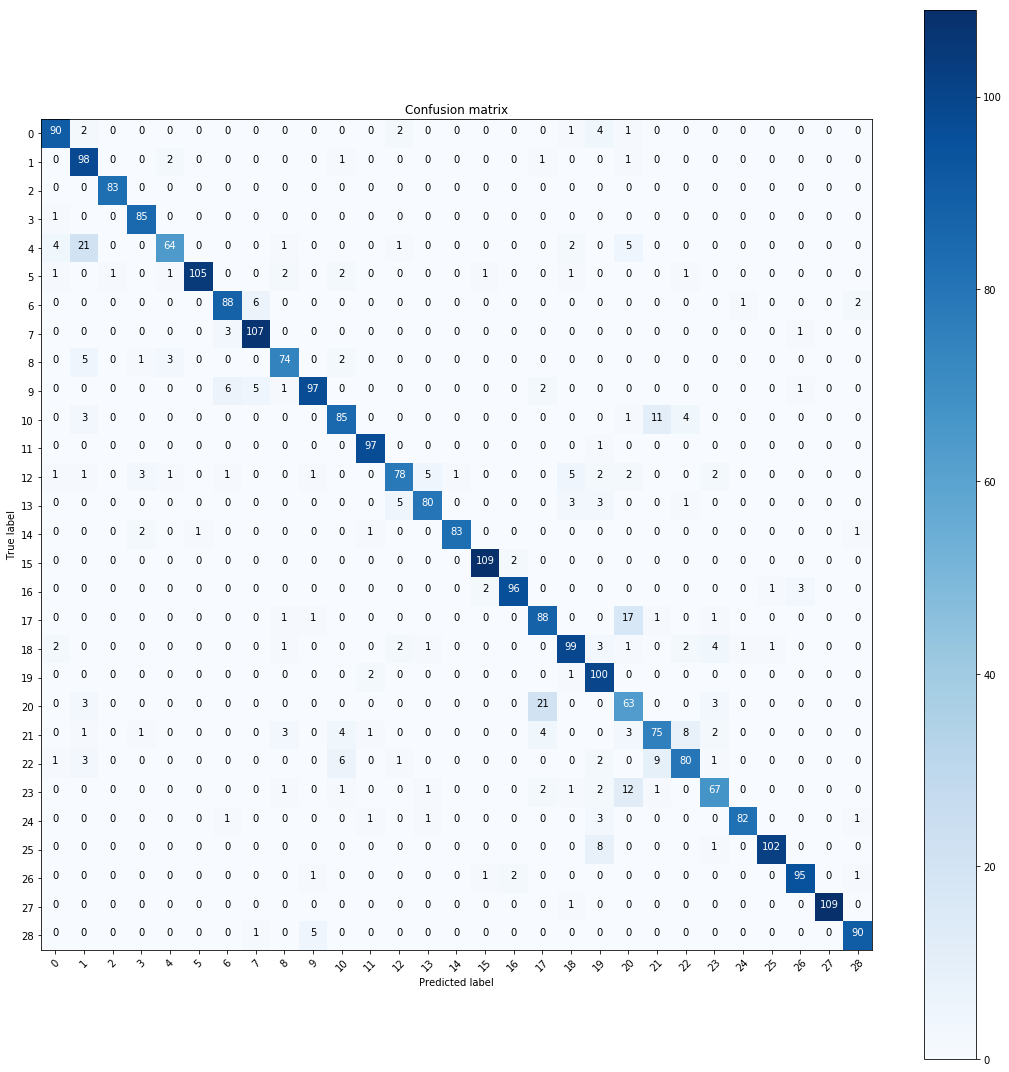

In [35]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
fig=plt.figure(figsize=(15, 15))
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(29))

In [38]:
np.shape(Y_val)

(2906, 29)

ValueError: cannot reshape array of size 12288 into shape (64,64)

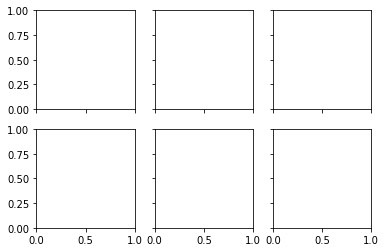

In [24]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]


array([539,  89, 981, 920, 989, 399])

0
0
0
0
0
0
